In [2]:
from SDP_interaction_inference import simulation
from SDP_interaction_inference.constraints import Constraint
from SDP_interaction_inference import optimization
import numpy as np
import matplotlib.pyplot as plt
import tqdm

In [3]:
rng = np.random.default_rng(7)

# Model free dependence test: SDP package

Validate results from 'model_free.ipynb' investigating model free dependence test using factorization of moments.

Previous work (in probability - moment case) was equivalent to $d = 2$ without moment matrices (and so NLP not SDP)

Investigate if $d > 2$ or the addition of moment matrices (so SDP) affect results.

In [31]:
# settings
interaction_values = [10.0, 5.0, 2.0, 1.5, 1.0, 0.75, 0.5, 0.25, 0.1, 0.0]
d_values = range(2, 11)
b = 0.5
runs = 3
rate = 1
n = 1000

# constraints
constraints_MM = Constraint(
    moment_bounds=True,
    moment_matrices=True,
    factorization=True
)
constraints_NO = Constraint(
    moment_bounds=True,
    moment_matrices=False,
    factorization=True
)

# sample beta
if b == 0:
    beta = np.ones(n)
else:
    beta = rng.beta(1, b, size=n)

# result arrays
results_MM = np.zeros((runs, len(d_values)))
times_MM = np.zeros((runs, len(d_values), len(interaction_values)))
results_NO = np.zeros((runs, len(d_values)))
times_NO = np.zeros((runs, len(d_values), len(interaction_values)))

# for each run
for i in tqdm.tqdm(range(runs)):

    # simulate dataset with range of interaction
    data = simulation.simulate_dataset_range_BD(interaction_values, cells=n, rate=rate)

    # downsample
    data = data.downsample(beta)

    # bootstrap (up to highest order used)
    data.bootstrap(d_values[-1])

    # for each d
    for j, d in enumerate(d_values):

        # test feasibility (with moment matrices)
        opt_MM = optimization.ModelFreeOptimization(data, d, constraints=constraints_MM, printing=False)
        opt_MM.analyse_dataset()

        # test feasibility (without moment matrices)
        opt_NO = optimization.ModelFreeOptimization(data, d, constraints=constraints_NO, printing=False)
        opt_NO.analyse_dataset()

        # record time & smallest interaction strength detected
        results_MM[i, j] = np.inf
        for k, solution in opt_MM.result_dict.items():
            times_MM[i, j, k] = solution['time']
            if solution['status'] == "INFEASIBLE":
                k_reg = interaction_values[k]
                prev = results_MM[i, j]
                if k_reg < prev:
                    results_MM[i, j] = k_reg

        results_NO[i, j] = np.inf
        for k, solution in opt_NO.result_dict.items():
            times_NO[i, j, k] = solution['time']
            if solution['status'] == "INFEASIBLE":
                k_reg = interaction_values[k]
                prev = results_NO[i, j]
                if k_reg < prev:
                    results_NO[i, j] = k_reg

100%|██████████| 3/3 [02:23<00:00, 47.87s/it]


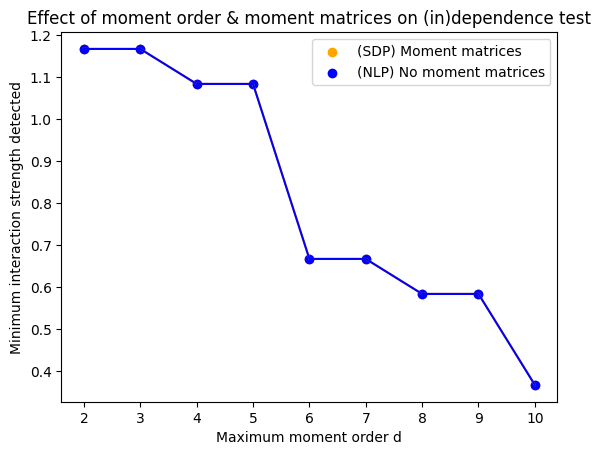

In [ ]:
# plot results
plt.plot(d_values, results_MM.mean(axis=0), color="orange")
plt.scatter(d_values, results_MM.mean(axis=0), label="(SDP) Moment matrices", color="orange")
plt.plot(d_values, results_NO.mean(axis=0), color="blue")
plt.scatter(d_values, results_NO.mean(axis=0), label="(NLP) No moment matrices", color="blue")
plt.xlabel("Maximum moment order d")
plt.ylabel("Minimum interaction strength detected")
plt.title("Effect of moment order & moment matrices on (in)dependence test")
plt.legend()

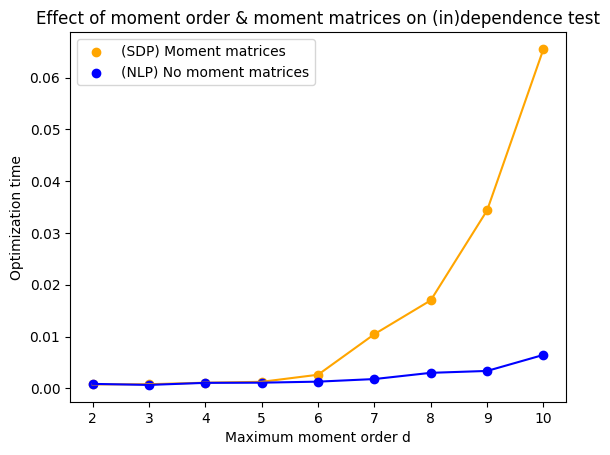

In [37]:
# plot results
plt.plot(d_values, times_MM.mean(axis=(0, 2)), color="orange")
plt.scatter(d_values, times_MM.mean(axis=(0, 2)), label="(SDP) Moment matrices", color="orange")
plt.plot(d_values, times_NO.mean(axis=(0, 2)), color="blue")
plt.scatter(d_values, times_NO.mean(axis=(0, 2)), label="(NLP) No moment matrices", color="blue")
plt.xlabel("Maximum moment order d")
plt.ylabel("Optimization time")
plt.title("Effect of moment order & moment matrices on (in)dependence test")
plt.legend()

## Results

Moment matrices have no effect on minimum interaction strength detected and only slow down optimization more as $d$ increases.

By removing them we avoid solving an SDP, instead only needing to solve an NLP. There is likely no effect because the bootstrapped moment intervals should (almost) always be valid sets of moments (modulo sampling error) and with no unobserved species the semidefinite constraints will not be violated.

Increasing $d$ lowers the minimum interaction strength that can be detected, even increasing up to $d = 10$.

However, the optimization time also increases, even without moment matrices. There may be other issues when using values of $d > 10$: the bootstrap bounds widen and provide less information (diminishing returns), and large moment orders mean large powers and large values which can overflow into negatives (false positives). See below for some investigation into large $d$ results:

In [72]:
# settings
interaction_values = [10.0, 5.0, 2.0, 1.5, 1.0, 0.75, 0.5, 0.25, 0.1, 0.0]
d = 30
b = 0.5
runs = 3
rate = 1
n = 1000

# constraints
constraints = Constraint(
    moment_bounds=True,
    moment_matrices=False,
    factorization=True
)

# sample beta
if b == 0:
    beta = np.ones(n)
else:
    beta = rng.beta(1, b, size=n)

# simulate dataset with range of interaction
data = simulation.simulate_dataset_range_BD(interaction_values, cells=n, rate=rate, tqdm_disable=False)

# downsample
data = data.downsample(beta)

# bootstrap (up to highest order used)
data.bootstrap(d)

# test feasibility (without moment matrices)
opt = optimization.ModelFreeOptimization(data, d, constraints=constraints, printing=False)
opt.analyse_dataset()

# display
for k, solution in opt.result_dict.items():
    k_reg = interaction_values[k]
    print(f"k_reg = {k_reg} is {solution['status']} in {solution['time']}")

100%|██████████| 10/10 [15:22<00:00, 92.26s/it]

k_reg = 10.0 is INFEASIBLE in 0.002000093460083008
k_reg = 5.0 is INFEASIBLE in 0.002000093460083008
k_reg = 2.0 is INFEASIBLE in 0.0010001659393310547
k_reg = 1.5 is INFEASIBLE in 0.0019998550415039062
k_reg = 1.0 is INFEASIBLE in 0.009000062942504883
k_reg = 0.75 is INFEASIBLE in 0.006999969482421875
k_reg = 0.5 is INFEASIBLE in 0.042999982833862305
k_reg = 0.25 is INFEASIBLE in 0.009000062942504883
k_reg = 0.1 is INFEASIBLE in 57.83299994468689
k_reg = 0.0 is INFEASIBLE in 2.13700008392334


In [67]:
# settings
interaction_values = [10.0, 5.0, 2.0, 1.5, 1.0, 0.75, 0.5, 0.25, 0.1, 0.0]
d_values = range(2, 20)
b = 0.5
runs = 3
rate = 1
n = 1000

# constraints
constraints = Constraint(
    moment_bounds=True,
    moment_matrices=False,
    factorization=True
)

# sample beta
if b == 0:
    beta = np.ones(n)
else:
    beta = rng.beta(1, b, size=n)

# result arrays
results = np.zeros((runs, len(d_values)))
times = np.zeros((runs, len(d_values), len(interaction_values)))

# for each run
for i in tqdm.tqdm(range(runs)):

    # simulate dataset with range of interaction
    data = simulation.simulate_dataset_range_BD(interaction_values, cells=n, rate=rate, tqdm_disable=False)

    # downsample
    data = data.downsample(beta)

    # bootstrap (up to highest order used)
    data.bootstrap(d_values[-1])

    # for each d
    for j, d in enumerate(d_values):

        # test feasibility (no moment matrices)
        opt = optimization.ModelFreeOptimization(data, d, constraints=constraints, printing=False, tqdm_disable=True)
        opt.analyse_dataset()

        # record time & smallest interaction strength detected
        results[i, j] = np.inf
        for k, solution in opt.result_dict.items():
            times[i, j, k] = solution['time']
            if solution['status'] == "INFEASIBLE":
                k_reg = interaction_values[k]
                prev = results[i, j]
                if k_reg < prev:
                    results[i, j] = k_reg

100%|██████████| 3/3 [21:30<00:00, 430.17s/it]


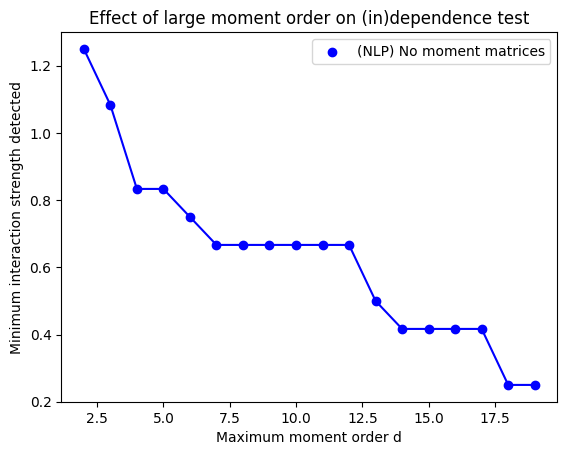

In [70]:
# plot results
plt.plot(d_values, results.mean(axis=0), color="blue")
plt.scatter(d_values, results.mean(axis=0), label="(NLP) No moment matrices", color="blue")
plt.xlabel("Maximum moment order d")
plt.ylabel("Minimum interaction strength detected")
plt.title("Effect of large moment order on (in)dependence test")
plt.legend()

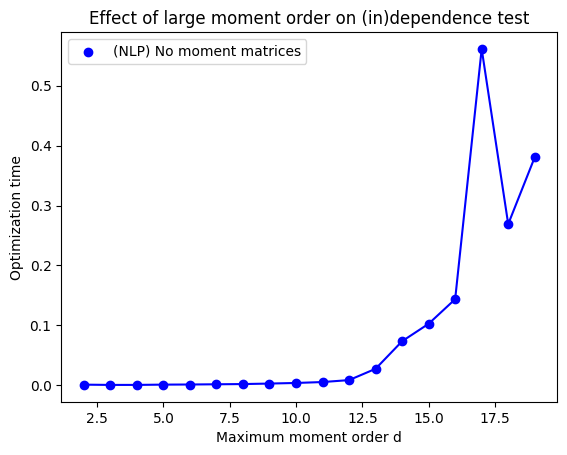

In [71]:
# plot results
plt.plot(d_values, times.mean(axis=(0, 2)), color="blue")
plt.scatter(d_values, times.mean(axis=(0, 2)), label="(NLP) No moment matrices", color="blue")
plt.xlabel("Maximum moment order d")
plt.ylabel("Optimization time")
plt.title("Effect of large moment order on (in)dependence test")
plt.legend()

## Large d results

For large values e.g. $d = 30$ (but also sometimes values as small as $15$) false positives can occur and lead to independent data being infeasible.

Even if there are not false positives, the optimization time begins to increase significantly past $d = 15$ or so.

While the minimum interaction strength detected continues to decrease (fairly steadily), it is risky to use large values, especially when considering moving to real data (which will be much more messy, etc).

## Correlation comparison

In [74]:
from SDP_interaction_inference import correlation

In [79]:
# settings
interaction_values = [10.0, 5.0, 2.0, 1.5, 1.0, 0.75, 0.5, 0.25, 0.1, 0.0]
b = 0.5
rate = 1
n = 1000

# sample beta
if b == 0:
    beta = np.ones(n)
else:
    beta = rng.beta(1, b, size=n)

# simulate dataset with range of interaction
data = simulation.simulate_dataset_range_BD(interaction_values, cells=n, rate=rate, tqdm_disable=False)

# downsample
data = data.downsample(beta)

# test dependence
corr = correlation.Correlation(data, printing=False)

# display
for k, solution in corr.result_dict.items():
    k_reg = interaction_values[k]
    p = solution['pvalue']
    if p < 0.05:
        status = "DEPENDENT"
    else:
        status = "INDEPENDENT"
    print(f"k_reg = {k_reg} is {status}")

100%|██████████| 10/10 [00:00<00:00, 560.97it/s]

k_reg = 10.0 is DEPENDENT
k_reg = 5.0 is DEPENDENT
k_reg = 2.0 is DEPENDENT
k_reg = 1.5 is DEPENDENT
k_reg = 1.0 is DEPENDENT
k_reg = 0.75 is INDEPENDENT
k_reg = 0.5 is INDEPENDENT
k_reg = 0.25 is INDEPENDENT
k_reg = 0.1 is INDEPENDENT
k_reg = 0.0 is INDEPENDENT


Correlation is able to detect interaction of around $1$, which is surpisingly good, but is still beaten by moments of order around $6$